Classes found: {'Cow': 0, 'Horse': 1}
Epoch 1/200 | G Loss: 7.2855 | D Loss: 1.0934
Epoch 2/200 | G Loss: 5.3446 | D Loss: 1.2660
Epoch 3/200 | G Loss: 5.4729 | D Loss: 1.5408
Epoch 4/200 | G Loss: 5.4797 | D Loss: 1.6877
Epoch 5/200 | G Loss: 5.8955 | D Loss: 1.4828
Epoch 6/200 | G Loss: 5.4330 | D Loss: 1.2199
Epoch 7/200 | G Loss: 4.0930 | D Loss: 1.3623
Epoch 8/200 | G Loss: 3.9193 | D Loss: 1.7030
Epoch 9/200 | G Loss: 4.1751 | D Loss: 1.4214
Epoch 10/200 | G Loss: 4.1784 | D Loss: 1.1210
Epoch 11/200 | G Loss: 3.4555 | D Loss: 1.5833
Epoch 12/200 | G Loss: 3.3588 | D Loss: 1.8236
Epoch 13/200 | G Loss: 3.8172 | D Loss: 1.2320
Epoch 14/200 | G Loss: 4.2069 | D Loss: 1.1704
Epoch 15/200 | G Loss: 4.6436 | D Loss: 1.1150
Epoch 16/200 | G Loss: 3.5335 | D Loss: 1.5333
Epoch 17/200 | G Loss: 4.1031 | D Loss: 1.1435
Epoch 18/200 | G Loss: 3.3699 | D Loss: 1.3497
Epoch 19/200 | G Loss: 3.7808 | D Loss: 1.7823
Epoch 20/200 | G Loss: 4.0840 | D Loss: 1.6369
Epoch 21/200 | G Loss: 5.1153 |

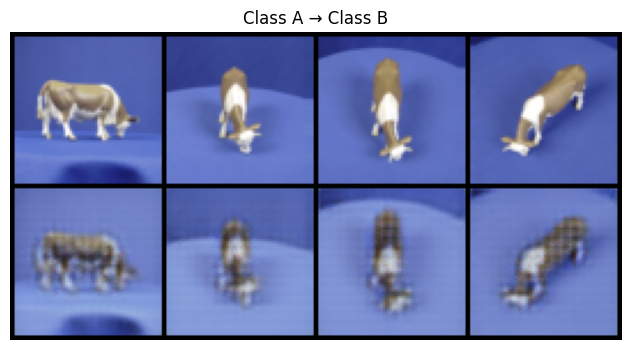

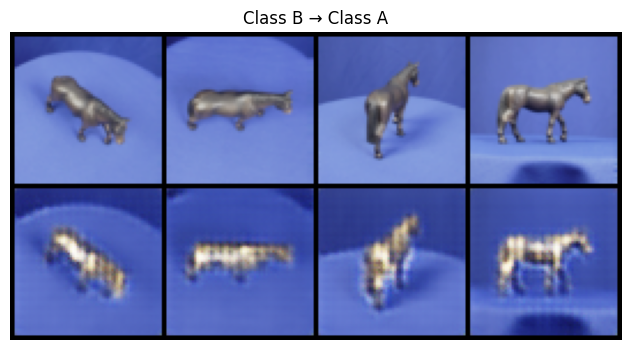

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import itertools

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ----------------------------
# Generator (Simple CNN)
# ----------------------------
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.ReLU(),
            nn.Conv2d(64, 128, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, 2, 1), nn.ReLU(),
            nn.ConvTranspose2d(64, 3, 4, 2, 1), nn.Tanh()
        )

    def forward(self, x):
        return self.main(x)

# ----------------------------
# Discriminator (Simple CNN)
# ----------------------------
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(64, 128, 4, 2, 1), nn.LeakyReLU(0.2),
            nn.Conv2d(128, 1, 4, 1, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.main(x)

# ----------------------------
# Data Loader (with 2 classes)
# ----------------------------
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = datasets.ImageFolder("dataset/Train", transform=transform)
class_indices = dataset.class_to_idx
print("Classes found:", class_indices)

# split by labels
class_a_idx = [i for i, (_, label) in enumerate(dataset.samples) if label == 0]
class_b_idx = [i for i, (_, label) in enumerate(dataset.samples) if label == 1]

from torch.utils.data import Subset
loader_a = DataLoader(Subset(dataset, class_a_idx), batch_size=4, shuffle=True)
loader_b = DataLoader(Subset(dataset, class_b_idx), batch_size=4, shuffle=True)

# ----------------------------
# Models & Optimizers
# ----------------------------
G_a2b = Generator().to(device)
G_b2a = Generator().to(device)
D_a = Discriminator().to(device)
D_b = Discriminator().to(device)

g_optimizer = optim.Adam(itertools.chain(G_a2b.parameters(), G_b2a.parameters()), lr=0.0002)
d_optimizer = optim.Adam(itertools.chain(D_a.parameters(), D_b.parameters()), lr=0.0002)

loss_GAN = nn.BCELoss()
loss_cycle = nn.L1Loss()
epochs=500

# ----------------------------
# Training Loop
# ----------------------------
for epoch in range(epochs):
    for (real_a, _), (real_b, _) in zip(loader_a, loader_b):
        real_a = real_a.to(device)
        real_b = real_b.to(device)
        # Get valid/fake label size based on D output
        with torch.no_grad():
            temp_out = D_a(real_a)
            valid = torch.ones_like(temp_out)
            fake = torch.zeros_like(temp_out)
            
        # ----------------------
        # Train Generators
        # ----------------------
        g_optimizer.zero_grad()

        fake_b = G_a2b(real_a)
        rec_a = G_b2a(fake_b)
        loss_cyc_a = loss_cycle(rec_a, real_a)

        fake_a = G_b2a(real_b)
        rec_b = G_a2b(fake_a)
        loss_cyc_b = loss_cycle(rec_b, real_b)

        loss_g = loss_GAN(D_b(fake_b), valid) + loss_GAN(D_a(fake_a), valid)
        loss_g_total = loss_g + 10 * (loss_cyc_a + loss_cyc_b)
        loss_g_total.backward()
        g_optimizer.step()

        # ----------------------
        # Train Discriminators
        # ----------------------
        d_optimizer.zero_grad()
        loss_d_a = (loss_GAN(D_a(real_a), valid) + loss_GAN(D_a(fake_a.detach()), fake)) * 0.5
        loss_d_b = (loss_GAN(D_b(real_b), valid) + loss_GAN(D_b(fake_b.detach()), fake)) * 0.5
        loss_d = loss_d_a + loss_d_b
        loss_d.backward()
        d_optimizer.step()

    print(f"Epoch {epoch+1}/{epochs} | G Loss: {loss_g_total.item():.4f} | D Loss: {loss_d.item():.4f}")

# ----------------------------
# Show Translated Images
# ----------------------------
def show_samples(input_imgs, translated_imgs, title):
    imgs = torch.cat((input_imgs, translated_imgs), 0).detach().cpu()
    imgs = imgs * 0.5 + 0.5
    grid = utils.make_grid(imgs, nrow=4)
    plt.figure(figsize=(8, 4))
    plt.title(title)
    plt.axis("off")
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.show()

G_a2b.eval()
G_b2a.eval()
with torch.no_grad():
    real_a = next(iter(loader_a))[0].to(device)
    real_b = next(iter(loader_b))[0].to(device)
    fake_b = G_a2b(real_a)
    fake_a = G_b2a(real_b)
    show_samples(real_a, fake_b, "Class A → Class B")
    show_samples(real_b, fake_a, "Class B → Class A")
